## Load FDA Information

In [11]:
import pandas as pd
from datetime import datetime


file_path = '../Datos/FDA Aproval.xlsx'
all_sheets_FDA = pd.ExcelFile(file_path).sheet_names
FDA_index = ["Russell2000"]*13 + ["S&P500"]*11
list_FDA_data = []

def first_occurrence_indices(vector, elements_to_find):
    indices = {element: None for element in elements_to_find}
    for i, item in enumerate(vector):
        if item in indices and indices[item] is None:
            indices[item] = i
        if all(index is not None for index in indices.values()):
            break
    return indices

counter_loop = -1
for i in all_sheets_FDA:
    counter_loop = counter_loop + 1
    df_FDA_Firm = pd.read_excel(file_path, sheet_name=i)
    FDA_names = df_FDA_Firm['Proprietary Name'].to_numpy()
    set_FDA_names = list(set(FDA_names))

    result_indices_FDA = list(first_occurrence_indices(FDA_names, set_FDA_names).values())
    final_FDA_df = df_FDA_Firm.iloc[result_indices_FDA]

    final_FDA_date = list(final_FDA_df["Approval Date"])
    final_FDA_date_format = []
    for j in final_FDA_date:
        final_FDA_date_format.append(datetime.strptime(j, '%b %d, %Y'))

    final_FDA_df["Approval Date"] = final_FDA_date_format
    final_FDA_df["Fin Index"] = FDA_index[counter_loop]
    list_FDA_data.append(final_FDA_df)
    

C:\Users\ignac\AppData\Local\Temp/ipykernel_11248/2488988711.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_FDA_df["Approval Date"] = final_FDA_date_format
C:\Users\ignac\AppData\Local\Temp/ipykernel_11248/2488988711.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_FDA_df["Fin Index"] = FDA_index[counter_loop]


## FDA Describing Plots

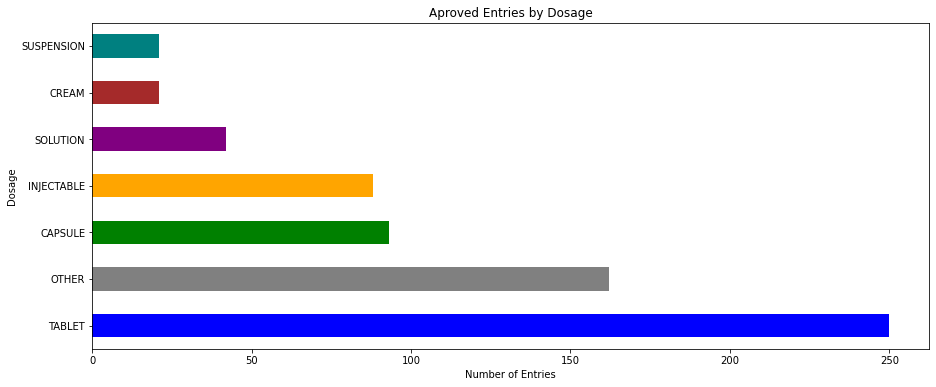

    Year        Index  Count
0   1982  Russell2000      6
1   1982       S&P500      6
2   1983  Russell2000      2
3   1983       S&P500      3
4   1984  Russell2000     11
..   ...          ...    ...
78  2021       S&P500      5
79  2022  Russell2000     12
80  2022       S&P500      8
81  2023  Russell2000     14
82  2023       S&P500      7

[83 rows x 3 columns]


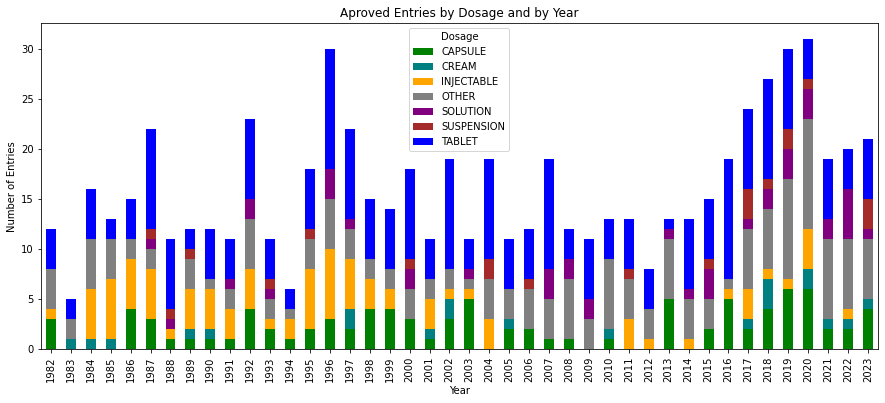

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px

list_FDA_data[0]

total_list_dosage = []
total_list_index = []
total_list_date = []

for i in list_FDA_data:
    total_list_dosage = total_list_dosage + list(i["Dosage Form"])
    total_list_index = total_list_index + list(i["Fin Index"])
    total_list_date = total_list_date + list(i["Approval Date"].dt.year)

total_list_dosage_modified_1 = ["TABLET" if x=="TABLET, EXTENDED RELEASE" else x for x in total_list_dosage]
total_list_dosage_modified_2 = ["CAPSULE" if x=="CAPSULE, EXTENDED RELEASE" else x for x in total_list_dosage_modified_1]
contemplated_dosage = ["TABLET","CAPSULE","INJECTABLE","SOLUTION","CREAM","SUSPENSION"]
total_list_dosage_modified_3 = ["OTHER" if x not in contemplated_dosage else x for x in total_list_dosage_modified_2]
df_plot_FDA = pd.DataFrame({'Dosage':total_list_dosage_modified_3,'Index': total_list_index,'Year': total_list_date})



%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)


#Index Static Plot
static_df_plot_index = df_plot_FDA['Index'].value_counts()
static_df_plot_index = pd.DataFrame(static_df_plot_index)
static_df_plot_index = static_df_plot_index.reset_index()
static_df_plot_index.columns = ['Index','Number of Entries']
px.bar(static_df_plot_index, y='Index', x='Number of Entries', orientation='h',
       color_discrete_sequence=['teal', 'brown'],
       labels={'Number of Entries': 'Number of Entries', 'Index': 'Index'},
       title='Approved Entries by Index')
plt.show()

#Dosage Static Plot
static_df_plot_dosage = df_plot_FDA['Dosage'].value_counts()
static_df_plot_dosage.plot(kind='barh', color = ["blue", "grey", "green", "orange", "purple", "brown", "teal"])
plt.xlabel('Number of Entries')
plt.ylabel('Dosage')
plt.title('Aproved Entries by Dosage')
plt.show()

#Dynamic Index Stack Bar Plot
aggregated_df_index = df_plot_FDA.groupby(['Year', 'Index']).size().reset_index(name='Count')
melted_df = pd.melt(aggregated_df_index, id_vars='Year', var_name='Index', value_name='Number of Entries')
print(aggregated_df_index)
fig = px.bar(melted_df, x='Year', y='Number of Entries', color='Index',
             labels={'Number of Entries': 'Number of Entries'},
             title='Approved Entries by Index and by Year')


#Dynamic Dosage Stack Bar Plot
aggregated_df_index = df_plot_FDA.groupby(['Year', 'Dosage']).size().reset_index(name='Count')
pivot_df = aggregated_df_index.pivot(index='Year', columns='Dosage', values='Count').fillna(0)
pivot_df.plot(kind='bar', stacked=True, color = ["green", "teal", "orange", "grey", "purple", "brown", "blue"])
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Aproved Entries by Dosage and by Year')
plt.show()

## Financial Information Load

In [13]:
import yfinance as yf


financial_counter = -1
stock_data_output_list = []

for i in all_sheets_FDA:
    financial_counter = financial_counter +1
    dates_to_view = list_FDA_data[financial_counter]["Approval Date"]
    minimum_date_plot = min(dates_to_view) - pd.DateOffset(days=28)
    maximum_date_plot = max(dates_to_view) + pd.DateOffset(days=28)
    stock_data = yf.download(i, start=minimum_date_plot, end=maximum_date_plot)
    stock_data_output = stock_data.loc[:,["Close","Volume"]].reset_index()
    FDA_date_list = [1 if x in list(dates_to_view) else 0 for x in list(stock_data_output["Date"])]
    stock_data_output["FDA Date"] = FDA_date_list
    stock_data_output_list.append(stock_data_output)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Financial Information Plot

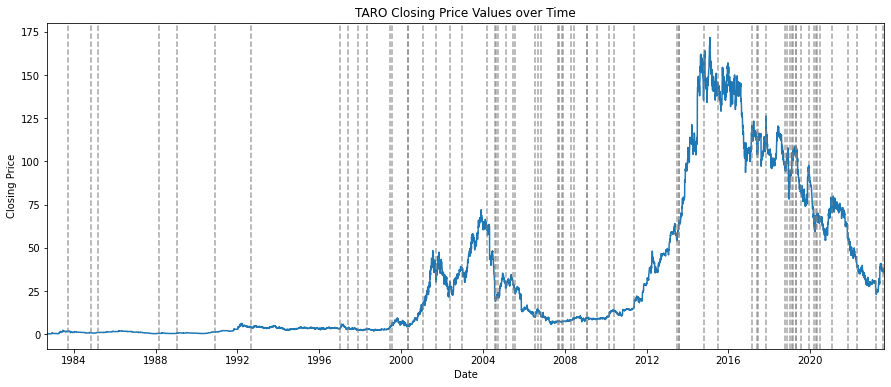

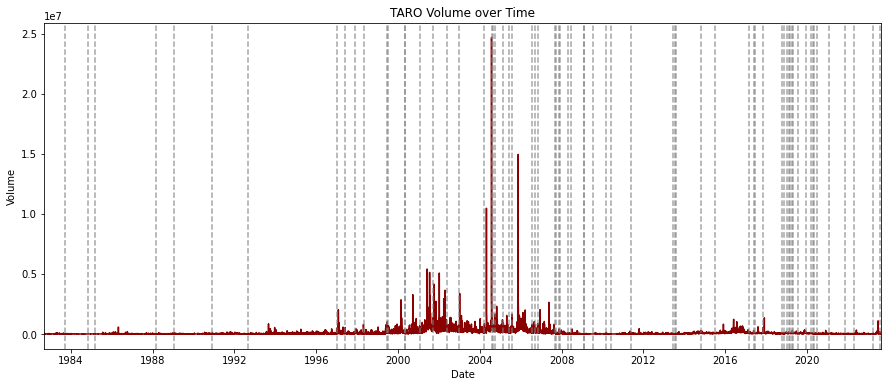

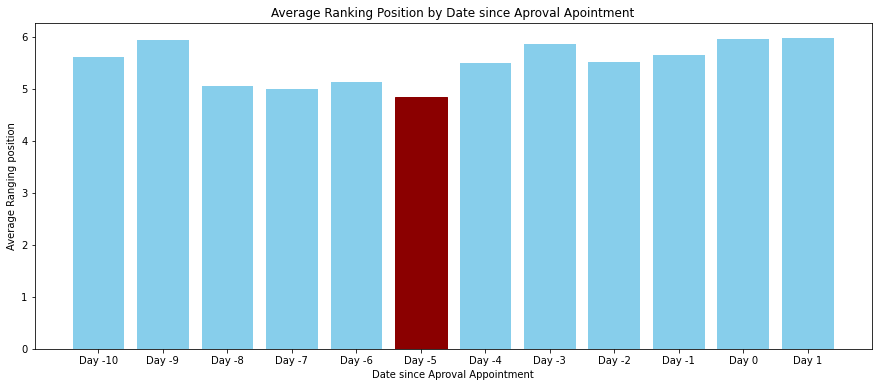

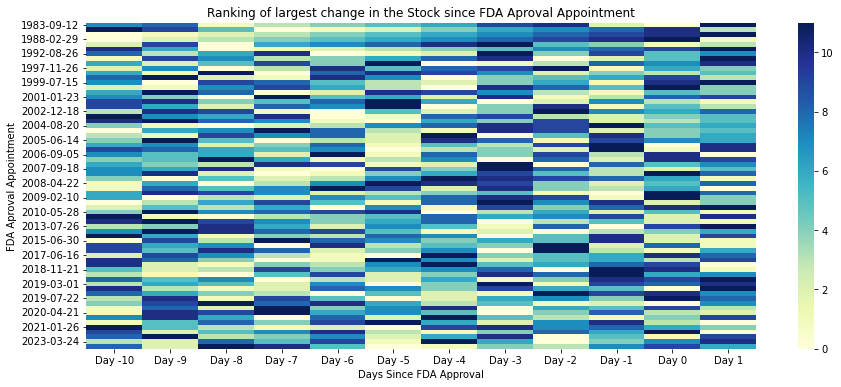

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [28]:
import numpy as np
import seaborn as sns



i = 10
df_plot = stock_data_output_list[i]


#Dynamic Price Plot
plt.plot(df_plot['Date'], df_plot['Close'])
for date, flag in zip(df_plot['Date'], df_plot['FDA Date']):
    if flag == 1:
        plt.axvline(x=date, color='grey', linestyle='--', alpha=0.7)
plt.xlim(df_plot['Date'].min(), df_plot['Date'].max())
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(all_sheets_FDA[i] + " " +'Closing Price Values over Time')
plt.show()


#Dynamic Volume Plot
for date, flag in zip(df_plot['Date'], df_plot['FDA Date']):
    if flag == 1:
        plt.axvline(x=date, color='grey', linestyle='--', alpha=0.7)
plt.xlim(df_plot['Date'].min(), df_plot['Date'].max())
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title(all_sheets_FDA[i] + " " +'Volume over Time')
plt.show()


#Impact Analysis in Price
matrix_rows = list(df_plot[df_plot["FDA Date"] == 1]["Date"])
matrix_cols = np.arange(-10, 2)
perc_change = np.diff(np.array(df_plot["Close"])) / np.array(df_plot["Close"])[:-1] * 100
perc_change_final = np.insert(perc_change, 0, 0)
df_output_price = pd.DataFrame(index=range(len(matrix_rows)), columns=range(len(matrix_cols)))


for j in np.arange(0,len(matrix_rows)):
    date_index = np.where(df_plot['Date'] == matrix_rows[j])
    selected_index = np.arange(date_index[0]-10,date_index[0]+2)
    selected_changes = perc_change_final[selected_index]
    order_of_changes = np.argsort(selected_changes)
    df_output_price.iloc[j] = order_of_changes

    
matrix_cols = ["Day {}".format(i) for i in matrix_cols]
df_output_price.columns = matrix_cols
df_output_price = df_output_price.set_index(pd.Index(matrix_rows))
average_success = df_output_price.mean()
selected_date = np.argmin(df_output_price.mean()) - 10

###Preference Plot
Categories = list(df_output_price.columns)
Average_ranking_position = list(average_success)
bars = plt.bar(Categories, Average_ranking_position, color='skyblue')
min_value_index = Average_ranking_position.index(min(Average_ranking_position))
bars[min_value_index].set_color('darkred')
plt.xlabel('Date since Aproval Appointment')
plt.ylabel('Average Ranging position')
plt.title('Average Ranking Position by Date since Aproval Apointment')
plt.show()


###HeatMap
data = {'Day -10': list(df_output_price.iloc[:,0]),
        'Day -9': list(df_output_price.iloc[:,1]),
        'Day -8': list(df_output_price.iloc[:,2]),
        'Day -7': list(df_output_price.iloc[:,3]),
        'Day -6': list(df_output_price.iloc[:,4]),
        'Day -5': list(df_output_price.iloc[:,5]),
        'Day -4': list(df_output_price.iloc[:,6]),
        'Day -3': list(df_output_price.iloc[:,7]),
        'Day -2': list(df_output_price.iloc[:,8]),
        'Day -1': list(df_output_price.iloc[:,9]),
        'Day 0': list(df_output_price.iloc[:,10]),
        'Day 1': list(df_output_price.iloc[:,11])}

df = pd.DataFrame(data)
df = df.set_index(pd.Index([timestamp.strftime('%Y-%m-%d') for timestamp in matrix_rows]))

sns.heatmap(df,annot=False, cmap="YlGnBu")
plt.xlabel('Days Since FDA Approval')
plt.ylabel('FDA Aproval Appointment')
plt.title("Ranking of largest change in the Stock since FDA Aproval Appointment")
plt.show()

print(type(df_plot["Date"][0]))

## Machine Learning

        X_axis                Line    Return
0   2023-05-04              Y_real -2.481482
1   2023-05-05              Y_real  3.949871
2   2023-05-08              Y_real  5.772743
3   2023-05-09              Y_real -1.105360
4   2023-05-10              Y_real  4.296198
..         ...                 ...       ...
217 2023-08-14  Y_predicted_WO_FDA  0.047267
218 2023-08-15  Y_predicted_WO_FDA  0.243324
219 2023-08-16  Y_predicted_WO_FDA  0.102349
220 2023-08-17  Y_predicted_WO_FDA  0.093457
221 2023-08-18  Y_predicted_WO_FDA  0.200662

[222 rows x 3 columns]


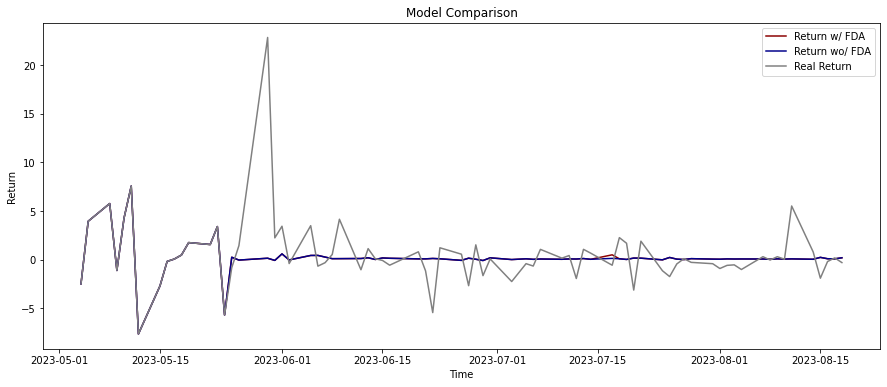

In [35]:
from sklearn.linear_model import LinearRegression

list_changed_series = perc_change_final
FDA_date = list(df_plot["FDA Date"])
modified_FDA_date = FDA_date[abs(selected_date):] + [0] * abs(selected_date)

X_set = {'Y_t-5': list_changed_series[1:-5],
        'Y_t-4':  list_changed_series[2:-4],
        'Y_t-3':  list_changed_series[3:-3],
        'Y_t-2':  list_changed_series[4:-2],
        'Y_t-1':  list_changed_series[5:-1],
        'FDA_YN': modified_FDA_date[6:]}
X_df = pd.DataFrame(X_set)

X_input = X_df.values
Y_input = list_changed_series[6:]

train_test_break = date_index - abs(selected_date) - 40
X_train = X_input[0:int(train_test_break[0])]
y_train = Y_input[0:int(train_test_break[0])]
X_test  = X_input[int(train_test_break[0]):]
y_test  = Y_input[int(train_test_break[0]):]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
FDA_coef = model.coef_[5]


##Model Without Coefficient
X_set_2 = {'Y_t-5': list_changed_series[1:-5],
        'Y_t-4':  list_changed_series[2:-4],
        'Y_t-3':  list_changed_series[3:-3],
        'Y_t-2':  list_changed_series[4:-2],
        'Y_t-1':  list_changed_series[5:-1]}
X_df_2 = pd.DataFrame(X_set_2)

X_input_2 = X_df_2.values
Y_input_2 = list_changed_series[6:]

train_test_break_2 = date_index - abs(selected_date) - 40
X_train_2 = X_input_2[0:int(train_test_break_2[0])]
y_train_2 = Y_input_2[0:int(train_test_break_2[0])]
X_test_2  = X_input_2[int(train_test_break_2[0]):]
y_test_2  = Y_input_2[int(train_test_break_2[0]):]

model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
y_pred_2 = model_2.predict(X_test_2)


X_axis = list(df_plot["Date"])[-(len(y_test)+15):]
Y_real = list(y_train[-15:]) + list(y_test)
Y_predicted_FDA = list(y_train[-15:]) + list(y_pred)
Y_predicted_WO_FDA = list(y_train[-15:]) + list(y_pred_2)

plt.plot(X_axis, Y_predicted_FDA, label='Return w/ FDA',color="darkred")
plt.plot(X_axis, Y_predicted_WO_FDA, label='Return wo/ FDA',color="darkblue")
plt.plot(X_axis, Y_real, label='Real Return',color="grey")
plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Model Comparison')
plt.legend()

plt.show()

## Agregated Measurements

In [549]:
list_company_name = []
list_index_operated = []
list_number_aproved_appointments = []
list_key_date = []
list_key_date_value_average_ranking = []
list_coeficient = []

company_name = all_sheets_FDA[i]
list_company_name.append(company_name)
index_operated = FDA_index[i]
list_index_operated.append(index_operated)
number_aproved_appointments = sum(df_plot['FDA Date'])
list_number_aproved_appointments.append(number_aproved_appointments)
key_date = selected_date
list_key_date.append(key_date)
key_date_value_average_ranking = min(df_output_price.mean())
list_key_date_value_average_ranking.append(key_date_value_average_ranking)
coeficient = FDA_coef
list_coeficient.append(coeficient)


In [552]:
list_company_name = []
list_index_operated = []
list_number_aproved_appointments = []
list_key_date = []
list_key_date_value_average_ranking = []
list_coeficient = []

for i in range(0,len(all_sheets_FDA)):
    print(i)
    df_plot = stock_data_output_list[i]

    #Impact Analysis in Price
    matrix_rows = list(df_plot[df_plot["FDA Date"] == 1]["Date"])
    matrix_cols = np.arange(-10, 2)
    perc_change = np.diff(np.array(df_plot["Close"])) / np.array(df_plot["Close"])[:-1] * 100
    perc_change_final = np.insert(perc_change, 0, 0)
    df_output_price = pd.DataFrame(index=range(len(matrix_rows)), columns=range(len(matrix_cols)))


    for j in np.arange(0,len(matrix_rows)):
        date_index = np.where(df_plot['Date'] == matrix_rows[j])
        selected_index = np.arange(date_index[0]-10,date_index[0]+2)
        selected_changes = perc_change_final[selected_index]
        order_of_changes = np.argsort(selected_changes)
        df_output_price.iloc[j] = order_of_changes

    
    matrix_cols = ["Day {}".format(i) for i in matrix_cols]
    df_output_price.columns = matrix_cols
    df_output_price = df_output_price.set_index(pd.Index(matrix_rows))
    average_success = df_output_price.mean()
    selected_date = np.argmin(df_output_price.mean()) - 10

    ###Preference Plot
    Categories = list(df_output_price.columns)
    Average_ranking_position = list(average_success)
    min_value_index = Average_ranking_position.index(min(Average_ranking_position))




    ###HeatMap
    data = {'Day -10': list(df_output_price.iloc[:,0]),
            'Day -9': list(df_output_price.iloc[:,1]),
            'Day -8': list(df_output_price.iloc[:,2]),
            'Day -7': list(df_output_price.iloc[:,3]),
            'Day -6': list(df_output_price.iloc[:,4]),
            'Day -5': list(df_output_price.iloc[:,5]),
            'Day -4': list(df_output_price.iloc[:,6]),
            'Day -3': list(df_output_price.iloc[:,7]),
            'Day -2': list(df_output_price.iloc[:,8]),
            'Day -1': list(df_output_price.iloc[:,9]),
            'Day 0': list(df_output_price.iloc[:,10]),
            'Day 1': list(df_output_price.iloc[:,11])}

    df = pd.DataFrame(data)
    df = df.set_index(pd.Index([timestamp.strftime('%Y-%m-%d') for timestamp in matrix_rows]))


    list_changed_series = perc_change_final
    FDA_date = list(df_plot["FDA Date"])
    modified_FDA_date = FDA_date[abs(selected_date):] + [0] * abs(selected_date)

    X_set = {'Y_t-5': list_changed_series[1:-5],
            'Y_t-4':  list_changed_series[2:-4],
            'Y_t-3':  list_changed_series[3:-3],
            'Y_t-2':  list_changed_series[4:-2],
            'Y_t-1':  list_changed_series[5:-1],
            'FDA_YN': modified_FDA_date[6:]}
    X_df = pd.DataFrame(X_set)

    X_input = X_df.values
    Y_input = list_changed_series[6:]

    train_test_break = date_index - abs(selected_date) - 40
    X_train = X_input[0:int(train_test_break[0])]
    y_train = Y_input[0:int(train_test_break[0])]
    X_test  = X_input[int(train_test_break[0]):]
    y_test  = Y_input[int(train_test_break[0]):]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    FDA_coef = model.coef_[5]


    ##Model Without Coefficient
    X_set_2 = {'Y_t-5': list_changed_series[1:-5],
            'Y_t-4':  list_changed_series[2:-4],
            'Y_t-3':  list_changed_series[3:-3],
            'Y_t-2':  list_changed_series[4:-2],
            'Y_t-1':  list_changed_series[5:-1]}
    X_df_2 = pd.DataFrame(X_set_2)

    X_input_2 = X_df_2.values
    Y_input_2 = list_changed_series[6:]

    train_test_break_2 = date_index - abs(selected_date) - 40
    X_train_2 = X_input_2[0:int(train_test_break_2[0])]
    y_train_2 = Y_input_2[0:int(train_test_break_2[0])]
    X_test_2  = X_input_2[int(train_test_break_2[0]):]
    y_test_2  = Y_input_2[int(train_test_break_2[0]):]

    model_2 = LinearRegression()
    model_2.fit(X_train_2, y_train_2)
    y_pred_2 = model_2.predict(X_test_2)


    X_axis = list(df_plot["Date"])[-(len(y_test)+15):]
    Y_real = list(y_train[-15:]) + list(y_test)
    Y_predicted_FDA = list(y_train[-15:]) + list(y_pred)
    Y_predicted_WO_FDA = list(y_train[-15:]) + list(y_pred_2)

    company_name = all_sheets_FDA[i]
    list_company_name.append(company_name)
    index_operated = FDA_index[i]
    list_index_operated.append(index_operated)
    number_aproved_appointments = sum(df_plot['FDA Date'])
    list_number_aproved_appointments.append(number_aproved_appointments)
    key_date = selected_date
    list_key_date.append(key_date)
    key_date_value_average_ranking = min(df_output_price.mean())
    list_key_date_value_average_ranking.append(key_date_value_average_ranking)
    coeficient = FDA_coef
    list_coeficient.append(coeficient)
    
final_output_list = [list_company_name,list_index_operated,list_number_aproved_appointments,list_key_date,
                     list_key_date_value_average_ranking,list_coeficient]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


## Final Plots

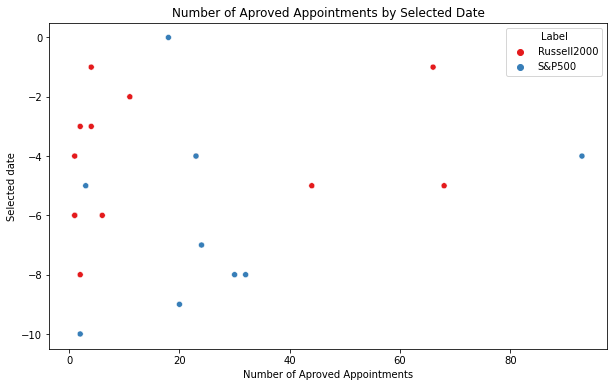

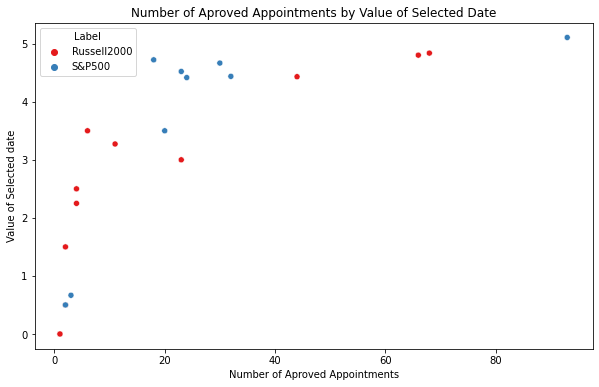

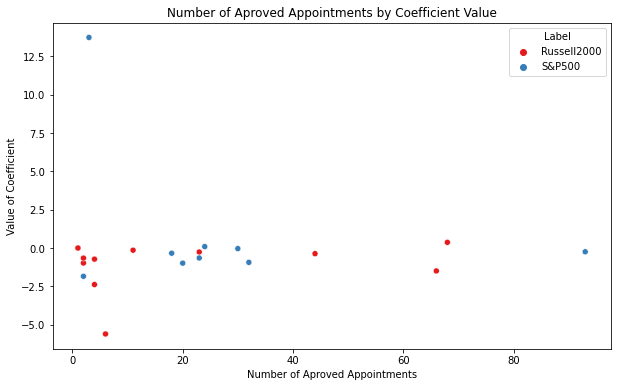

In [562]:
from sklearn.preprocessing import LabelEncoder

data = {'X': list_number_aproved_appointments, 'Y': list_key_date, 'Label': list_index_operated}
df = pd.DataFrame(data)
sns.scatterplot(x='X',y='Y',hue='Label',data=df,palette='Set1')
plt.xlabel("Number of Aproved Appointments")
plt.ylabel("Selected date")
plt.title("Number of Aproved Appointments by Selected Date")
plt.show()


data = {'X': list_number_aproved_appointments, 'Y': list_key_date_value_average_ranking, 'Label': list_index_operated}
df = pd.DataFrame(data)
sns.scatterplot(x='X',y='Y',hue='Label',data=df,palette='Set1')
plt.xlabel("Number of Aproved Appointments")
plt.ylabel("Value of Selected date")
plt.title("Number of Aproved Appointments by Value of Selected Date")
plt.show()

data = {'X': list_number_aproved_appointments, 'Y': list_coeficient, 'Label': list_index_operated}
df = pd.DataFrame(data)
sns.scatterplot(x='X',y='Y',hue='Label',data=df,palette='Set1')
plt.xlabel("Number of Aproved Appointments")
plt.ylabel("Value of Coefficient")
plt.title("Number of Aproved Appointments by Coefficient Value")
plt.show()


In [9]:
col_counter = 1
'xaxis'+str(col_counter)


'xaxis1'